In [1]:
import numpy as np
import ringity as rng
import networkx as nx
import matplotlib.pyplot as plt

from collections import Counter
from scipy.spatial.distance import squareform
from ringity.classes.network_model import NetworkBuilder

## Testing expected conditional probability and similairty

In [192]:
N = 2**10
beta = 0.99999999
alpha = 0.25
K = 0.5

rate  = np.tan(np.pi * (1-beta) / 2)
delay = 2/np.pi * np.arctan(rate)

network_builder = NetworkBuilder(random_state = 1234)
network_builder.set_distribution('exponential', scale = 1/rate)
network_builder.instantiate_positions(N)
network_builder.calculate_distances(metric = 'euclidean', circular = True)
network_builder.calculate_similarities(alpha = alpha, sim_func = 'box_cosine')
network_builder.calculate_probabilities(slope=K, intercept=0)

In [193]:
rho = rng.classes.network_model.interaction_strength_to_density(K=K, a=alpha, rate=rate)

In [194]:
def expected_conditional_similarity(theta, rate, a):
    if np.isclose(rate, 0, atol=1e-7):
        return a
    
    if theta < np.pi:
        if theta <= 2*np.pi*a:
            norm = 1 / (1 - np.exp(-2*np.pi*rate)) / (2*a*np.pi*rate)
            
            theta_term = -theta*rate * (1 - np.exp(-2*np.pi*rate))
            
            term1  = -2*np.exp(-rate*theta) + 1
            term21 =  np.exp(-rate*theta)*(np.exp(-2*a*np.pi*rate) + np.exp((2*a*np.pi - 2*np.pi)*rate))
            term22 = -np.exp(-2*np.pi*rate)
            
            return norm*(term1 + term21 + term22 + theta_term) + 1
        else:
            theta_term = np.exp(-rate*theta) / (1 - np.exp(-2*np.pi*rate))
            alpha_term = (np.cosh(-rate*2*np.pi*a) - 1) / (a*np.pi*rate)
            return theta_term * alpha_term
        
    else:
        norm = 2*rate*np.exp(-rate*theta) / (1 - np.exp(-2*np.pi*rate))
        
        def undef_int(t):
            return (np.exp(np.pi*rate)*(np.cosh((np.pi - t)*rate) + (-2*a*np.pi + t)*rate*np.sinh((np.pi - t)*rate)))/(2*a*np.pi*rate**2)
        
        if 2*np.pi - theta <= 2*np.pi*a:
            term1 = (-1 + np.cosh((2*np.pi - theta)*rate) + (2*(-1 + a)*np.pi + theta)*rate*np.sinh((2*np.pi - theta)*rate))/(2*a*np.pi*rate**2)
            term2 = undef_int(2*np.pi*a) - undef_int(2*np.pi - theta)
            return norm*term1 + norm*term2
        else:
            return norm*(np.sinh(a*np.pi*rate)**2)/(a*np.pi*rate**2)

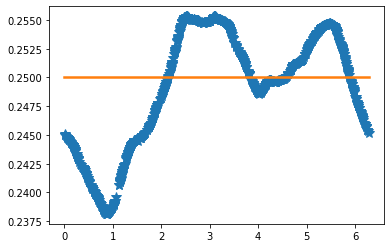

In [195]:
thetas = np.linspace(0, 2*np.pi, 50)
simis = [expected_conditional_similarity(theta=theta, rate=rate, a=alpha)
                    for theta in thetas]

plt.plot(network_builder.positions,
         network_builder.similarities.mean(axis=0), '*', markersize=10)
plt.plot(thetas, simis, linewidth=2.5)

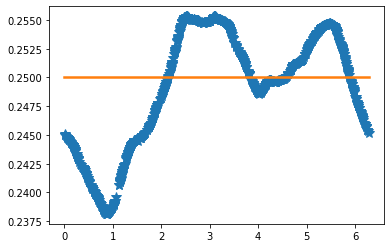

In [196]:
thetas = np.linspace(0, 2*np.pi, 50)
simis = [expected_conditional_similarity(theta=theta, rate=rate, a=alpha)
                    for theta in thetas]

plt.plot(network_builder.positions,
         network_builder.similarities.mean(axis=0), '*', markersize=10)
plt.plot(thetas, simis, linewidth=2.5)

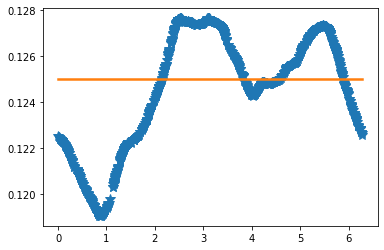

In [197]:
thetas = np.linspace(0, 2*np.pi, 50)
simis = [K*expected_conditional_similarity(theta=theta, rate=rate, a=alpha)
                    for theta in thetas]

plt.plot(network_builder.positions,
         network_builder.probabilities.mean(axis=0), '*', markersize=10)
plt.plot(thetas, simis, linewidth=2.5)

In [198]:
network_builder.instantiate_network()

In [199]:
G = nx.from_numpy_array(squareform(network_builder.network.astype(int)))

In [200]:
nx.density(G), rho

(0.12510882514662758, 0.13527904783986755)

In [201]:
random_degrees = []

for _ in range(2**5):
    print(_, end='\r')

    network_builder = NetworkBuilder()
    network_builder.set_distribution('exponential', scale = 1/rate)
    network_builder.instantiate_positions(N)
    network_builder.calculate_distances(metric = 'euclidean', circular = True)
    network_builder.calculate_similarities(alpha = alpha, sim_func = 'box_cosine')
    network_builder.calculate_probabilities(slope=K, intercept=0)
    network_builder.instantiate_network()
    
    G = nx.from_numpy_array(squareform(network_builder.network.astype(int)))

    random_degrees.extend([deg for (_, deg) in nx.degree(G)])

In [202]:
random_positions = []

position_generator = NetworkBuilder()
position_generator.set_distribution('exponential', scale = 1/rate)

for _ in range(10):
    position_generator.instantiate_positions(N)
    random_positions.extend(position_generator.positions)

In [203]:
deg_dist0_obs = random_degrees
deg_dist0_exp = [p for theta in random_positions
                   for p in np.random.binomial(N-1, K*expected_conditional_similarity(theta=theta, rate=rate, a=alpha), size=100)]

In [204]:
degs_exp, freqs_exp = zip(*Counter(deg_dist0_exp).items())
freqs_exp = np.array(freqs_exp) / sum(freqs_exp)

degs_obs, freqs_obs = zip(*Counter(deg_dist0_obs).items())
freqs_obs = np.array(freqs_obs) / sum(freqs_obs)

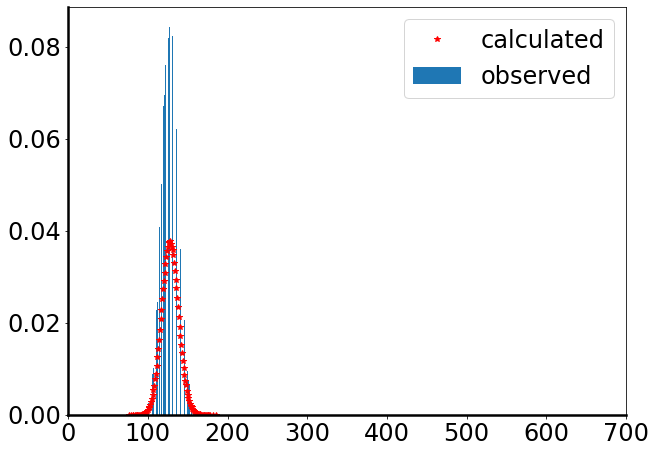

In [205]:
fig, ax = plt.subplots(figsize=(10,7.5))

ax.hist(deg_dist0_obs, bins=200, density=True, label='observed');
ax.plot(degs_exp, freqs_exp, 'r*', label='calculated');

ax.set_xlim(0, 700)

rng.ax_setup(ax)

ax.legend(fontsize=24);

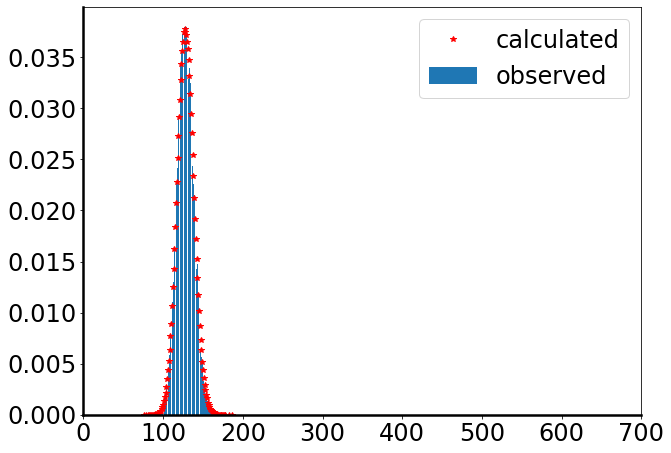

In [206]:
fig, ax = plt.subplots(figsize=(10,7.5))

ax.bar(degs_obs, freqs_obs, label='observed');
ax.plot(degs_exp, freqs_exp, 'r*', label='calculated');

ax.set_xlim(0, 700)

rng.ax_setup(ax)

ax.legend(fontsize=24);

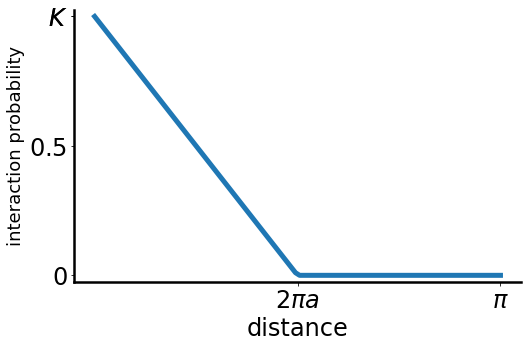

In [175]:
x = np.linspace(0, np.pi, 100)
y = K*(1-x/(2*np.pi*alpha)).clip(0)

fig, ax = plt.subplots(figsize = (8,5))

#ax.set_title(r"Distance to interaction probability ($a < 0.5$)", fontsize = 24)
ax.plot(x, y, linewidth = 5, label = r"$K \cdot \left| 1- \frac{d\left(\theta_i, \theta_j\right)}{2\pi\alpha} \right|_+$")


plt.xticks([2*np.pi*alpha, np.pi], [r'$2\pi a$', r'$\pi$'])
plt.yticks([0, 0.5, 1, K], [r'$0$', r'$0.5$', r'$1$', r'$K$'])

ax.set_ylim(-0.025, 1.025)

ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)

ax.set_xlabel('distance', fontsize=24)
ax.set_ylabel('interaction probability', fontsize=18)

rng.ax_setup(ax)

#ax.legend(fontsize = 18);

In [176]:
rng.ring_score(G)

0.9721374020157836

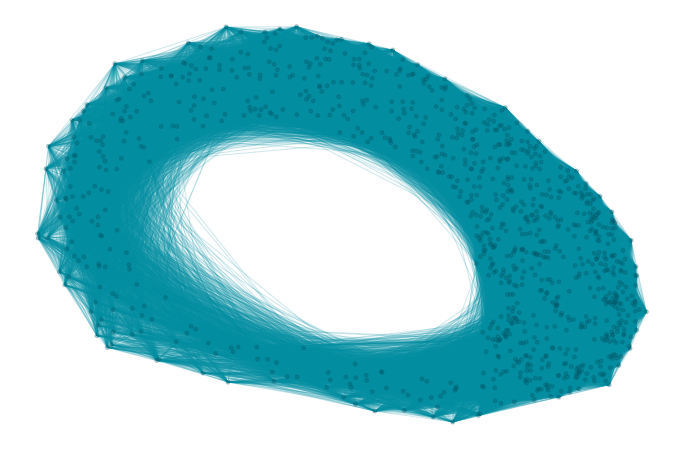

In [177]:
rng.plot_nx(G)

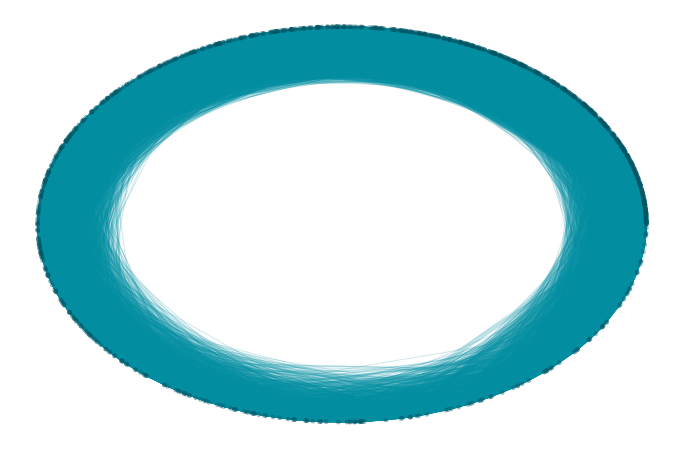

In [180]:
rng.plot_nx(G, pos=pos)

In [179]:
pos = {node: (np.cos(theta), np.sin(theta)) for (node, theta) in zip(G, network_builder._positions)}

Text(0, 0.5, 'frequency')

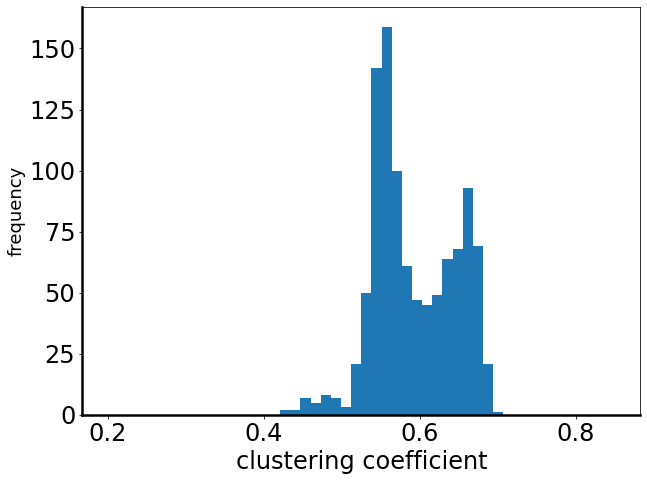

In [186]:
fig, ax = plt.subplots(figsize=(10,7.5))

ax.hist(rng.clustering_coefficient(G), bins=50, range=(0.2, 0.85));

rng.ax_setup(ax)

ax.set_xlabel('clustering coefficient', fontsize=24)
ax.set_ylabel('frequency', fontsize=18)